In [18]:
import librosa
import re
import os
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn import svm
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
import pickle

In [2]:
# settings
dataPath = ".\\wav"
classes = 40

In [3]:
# find personId from the file path
def getPerson(filePath):
    matchObj = re.match(r'.*id(\d+).*', filePath)
    return int(matchObj.group(1))-10270

# sample class
class VoiceSample:
    path = ''
    personId = -1
    feature = []
    
    def __init__(self, path):
        self.path = path
        self.personId = getPerson(path)
        self.getAvgMFCC()
        
    def __str__(self):
        return self.path
    
    def getAvgMFCC(self):
        y, sr = librosa.load(self.path,sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=13)
        self.feature = np.append(np.average(mfccs, 1), np.std(mfccs, 1))

In [4]:
def gci(filepath, res):
    files = os.listdir(filepath)
    for fi in tqdm(files):
        fi_d = os.path.join(filepath,fi)
        if os.path.isdir(fi_d):
            gci(fi_d, res)                  
        else:
            voice = VoiceSample(fi_d)
            res[0].append(voice)
            res[1].append(voice.personId)
    
def getList(filepath):
    res = [[],[]]
    gci(filepath, res)
    return res

#递归遍历/root目录下所有文件
data = getList(dataPath)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data[0], data[1], test_size=0.33, random_state=42)

In [19]:
res = [X_train, X_test, y_train, y_test]
pickle.dump(res, open("data", "wb"))

In [6]:
def extractX(X):
    res = []
    for voice in X:
        res.append(voice.feature)
    return res

in_X_train = extractX(X_train)

In [7]:
gamma = [0.0006, 0.0008, 0.001, 0.0012, 0.0014]

In [8]:
in_X_test = extractX(X_test)
y_test = np.asarray(y_test)

for g in gamma:
    clf =svm.SVC(kernel = "rbf", gamma=g)
    clf.fit(in_X_train, y_train) 
    y_pred = clf.predict(in_X_test)
    accuracy = accuracy_score(y_test,y_pred)
    print 'gamma: ', g, 'accuracy: ',accuracy

gamma:  0.0006 accuracy:  0.7930391547545059
gamma:  0.0008 accuracy:  0.7967681789931634
gamma:  0.001 accuracy:  0.7917961466749533
gamma:  0.0012 accuracy:  0.783716594157862
gamma:  0.0014 accuracy:  0.7712865133623369


In [9]:
clf =svm.SVC(kernel = "rbf", gamma=0.001)
clf.fit(in_X_train, y_train) 
y_score = clf.decision_function(np.asarray(in_X_test))

In [10]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(classes):
    fpr[i], tpr[i], _ = roc_curve(np.where(y_test == i, 1, 0), y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

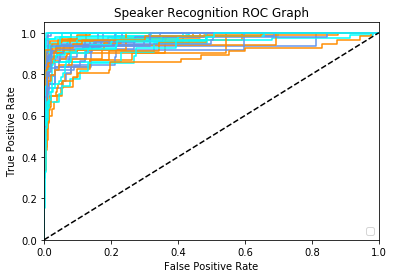

In [11]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(classes), colors):
    plt.plot(fpr[i], tpr[i], color=color)
             #label='ROC curve of class {0} (area = {1:0.2f})'
             #''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Speaker Recognition ROC Graph')
plt.legend(loc="lower right")
plt.show()

In [12]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

IndexError: too many indices for array

In [ ]:
y_test = np.asarray(y_test).astype(int)
y_test.shape

In [ ]:
len(in_X_test)

In [ ]:
np.asarray(in_X_test).shape

In [ ]:
clf =svm.SVC(kernel = "rbf", gamma=0.001)
#clf.fit(in_X_train, y_train)
y_score = clf.fit(in_X_train, y_train).decision_function(np.asarray(in_X_test))

In [ ]:
print y_score.shape

In [ ]:
print y_test.shape

In [ ]:
fpr, tpr, thresholds = roc_curve(np.asarray(y_test), y_score, pos_label = 1)

plt.figure(figsize = (10, 10))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('ROC Curve', fontsize = 25)

plt.show()

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(40)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_score.shape

In [ ]:
X_train[0].feature

In [ ]:
res.shape

In [ ]:
y, sr = librosa.load('./wav/id10270/5r0dWxy17C8/00001.wav',sr=None)
mfccs = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=13)

In [ ]:
print mfccs

In [ ]:
np.average(mfccs, 1)

In [ ]:
print mfccs.shape

In [ ]:
mfccs

In [ ]:
y, sr = librosa.load('./wav/id10270/5r0dWxy17C8/00002.wav',sr=None)
mfccs = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=13)

In [ ]:
mfccs